# September 11 - Semi-supervised final results

In [1]:
# Imports
import sys
import os
import time
import math

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [2]:
# Fix the colour scheme for each particle type
color_dict = {"gamma":"red", "e":"blue", "mu":"green"}

In [12]:
# Plot the ROC curve for one vs another class
def plot_new_ROC(softmaxes, labels, energies, softmax_index_dict, label_0, label_1, 
                 min_energy=0, max_energy=1500, show_plot=False, save_path=None):
    
    assert softmaxes is not None
    assert labels is not None
    assert softmax_index_dict  is not None
    assert softmaxes.shape[0] == labels.shape[0]
    assert label_0 in softmax_index_dict.keys()
    assert label_1 in softmax_index_dict.keys()
    
    #------------------------------------------------------------------------
    # Create a boolean map to select events in the user-defined energy range
    #------------------------------------------------------------------------
    
    energy_slice_map = [False for i in range(len(energies))]
    
    for i in range(len(energies)):
        if(energies[i] >= min_energy and energies[i] < max_energy):
                energy_slice_map[i] = True
                
    curr_softmax = softmaxes[energy_slice_map]
    curr_labels = labels[energy_slice_map]
    
    #------------------------------------------------------------------------
    # Extract the softmax and true label values for signal and background events
    #------------------------------------------------------------------------
    
    # Extract the useful softmax and labels from the input arrays
    softmax_0 = curr_softmax[curr_labels==softmax_index_dict[label_0]]
    labels_0 = curr_labels[curr_labels==softmax_index_dict[label_0]] 
    
    softmax_1 = curr_softmax[curr_labels==softmax_index_dict[label_1]]
    labels_1 = curr_labels[curr_labels==softmax_index_dict[label_1]]
    
    # Add the two arrays
    softmax = np.concatenate((softmax_0, softmax_1), axis=0)
    labels = np.concatenate((labels_0, labels_1), axis=0)

    #------------------------------------------------------------------------
    # Compute the ROC curve and the AUC for class corresponding to label 0
    #------------------------------------------------------------------------
    
    fpr, tpr, threshold = roc_curve(labels, softmax[:,softmax_index_dict[label_0]], pos_label=softmax_index_dict[label_0])
    roc_auc = auc(fpr, tpr)
    
    tnr = 1. - fpr
    
    if show_plot or save_path is not None:
        
        # TNR vs TPR plot
        fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
        ax.tick_params(axis="both", labelsize=20)

        ax.plot(tpr, tnr, color=color_dict[label_0],
                 label=r"$\{0}$, AUC ${1:0.3f}$".format(label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
                 linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=color_dict[label_0])

        # Show coords of individual points near x = 0.2, 0.5, 0.8
        todo = {0.2: True, 0.5: True, 0.8: True}
        for xy in zip(tpr, tnr):
            xy = (round(xy[0], 4), round(xy[1], 4))
            for point in todo.keys():
                if xy[0] >= point and todo[point]:
                    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                    todo[point] = False

        ax.grid(True, which='both', color='grey')
        xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
        ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

        ax.set_xlabel(xlabel, fontsize=20) 
        ax.set_ylabel(ylabel, fontsize=20)

        ax.set_title(r"${0} \leq E < {1}$".format(round(min_energy,2), round(max_energy,2)), fontsize=20)
        ax.legend(loc="upper right", prop={"size":20})
        
        plt.margins(0.1)
        
    if save_path is not None:
        plt.savefig(save_path)
    
    if show_plot:
        plt.show()
        
    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

## M1 model

In [49]:
num_samples = [11250, 22500, 45000, 90000]

dumps = ["20190911_211631", "20190911_211408", "20190911_211212", "20190911_211008"]

dump_dir = "/home/akajal/WatChMaL/VAE/dumps/"
dump_file = "/test_validation_iteration_dump.npz"
softmax_index_dict = {"gamma":0, "e":1, "mu":2}

-------------------------------------------------------------
Plotting the ROC curve for M1 model trained using 11250 samples
-------------------------------------------------------------


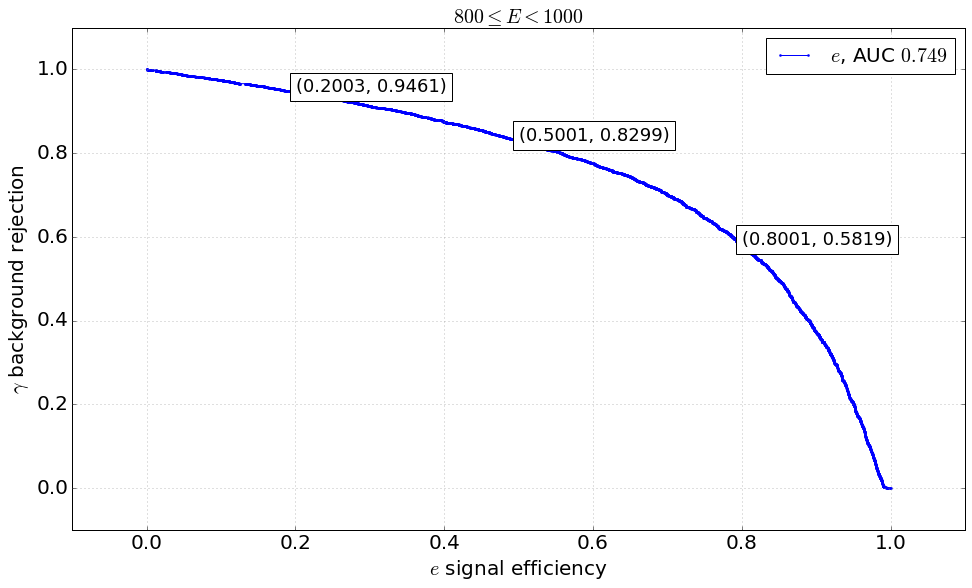

-------------------------------------------------------------
Plotting the ROC curve for M1 model trained using 22500 samples
-------------------------------------------------------------


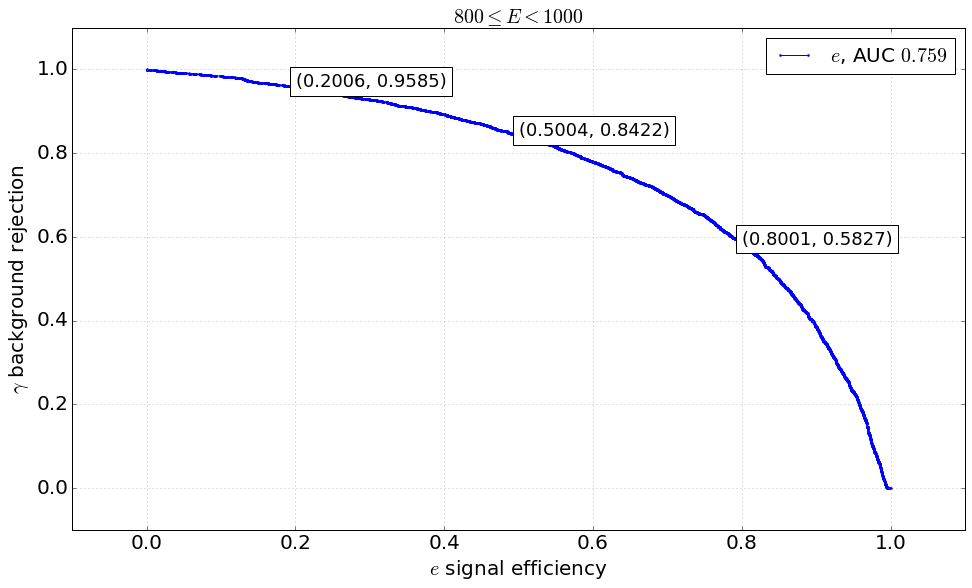

-------------------------------------------------------------
Plotting the ROC curve for M1 model trained using 45000 samples
-------------------------------------------------------------


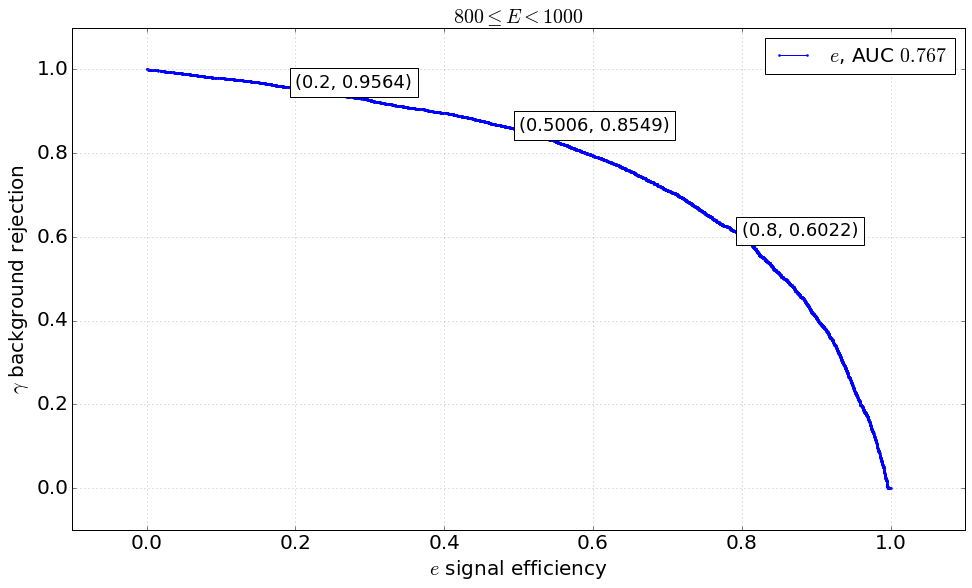

-------------------------------------------------------------
Plotting the ROC curve for M1 model trained using 90000 samples
-------------------------------------------------------------


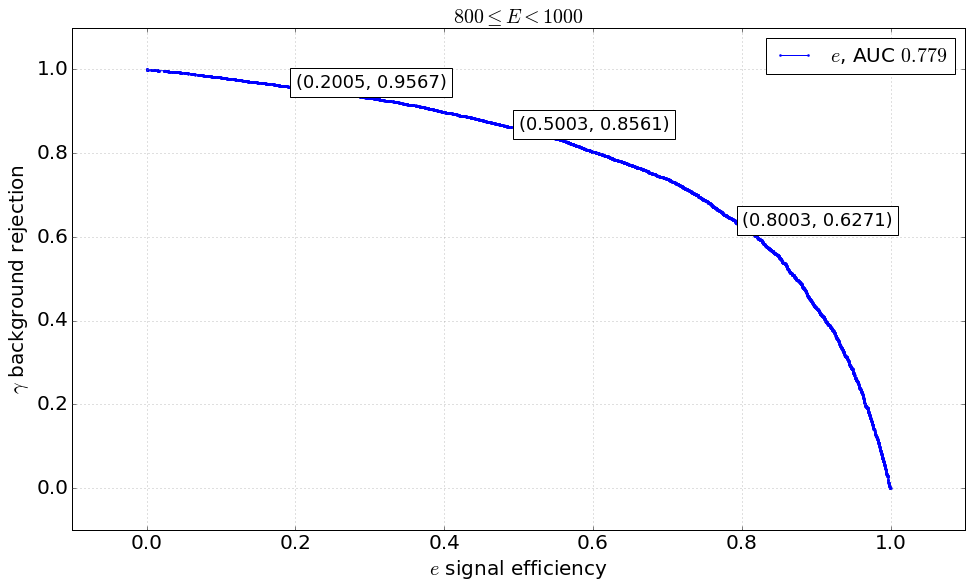

In [50]:
for num_sample, dump in zip(num_samples, dumps):
    
    print("-------------------------------------------------------------")
    print("Plotting the ROC curve for M1 model trained using {0} samples".format(num_sample))
    print("-------------------------------------------------------------")
    
    test_dump_path = dump_dir + dump + dump_file
    test_dump_np = np.load(test_dump_path)
    
    test_softmax  = test_dump_np['softmax'].reshape(-1, 3)
    test_labels   = test_dump_np['labels'].reshape(-1)
    test_energies = test_dump_np['energies'].reshape(-1)
    
    roc_metrics = plot_new_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "gamma", min_energy=800,
                               max_energy=1000, show_plot=True)

## Fully supervised model

In [51]:
num_samples = [11250, 22500, 45000, 90000]

dumps = ["20190911_213045", "20190911_212854", "20190911_212700", "20190911_212051"]

dump_dir = "/home/akajal/WatChMaL/VAE/dumps/"
dump_file = "/test_validation_iteration_dump.npz"
softmax_index_dict = {"gamma":0, "e":1, "mu":2}

-------------------------------------------------------------
Plotting the ROC curve for CNN model trained using 11250 samples
-------------------------------------------------------------


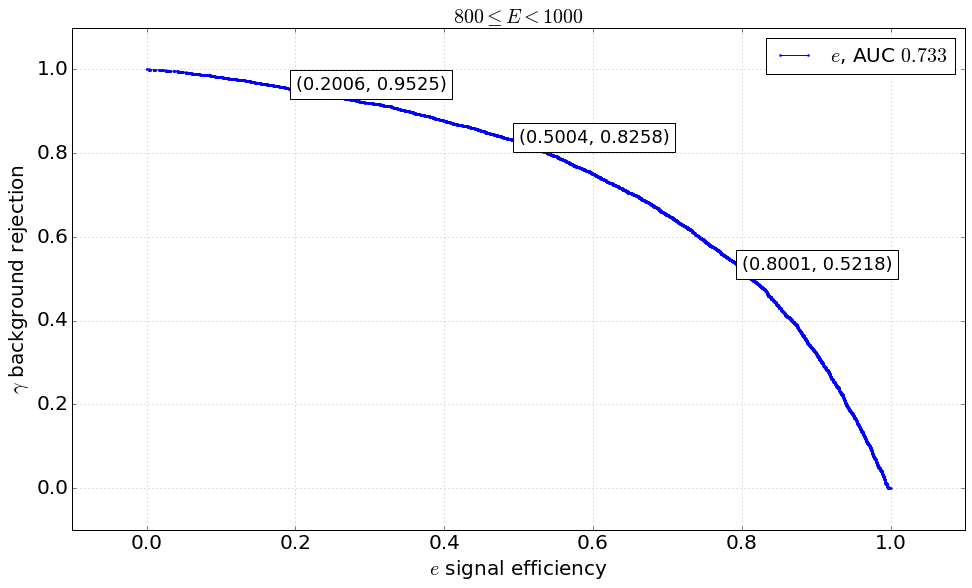

-------------------------------------------------------------
Plotting the ROC curve for CNN model trained using 22500 samples
-------------------------------------------------------------


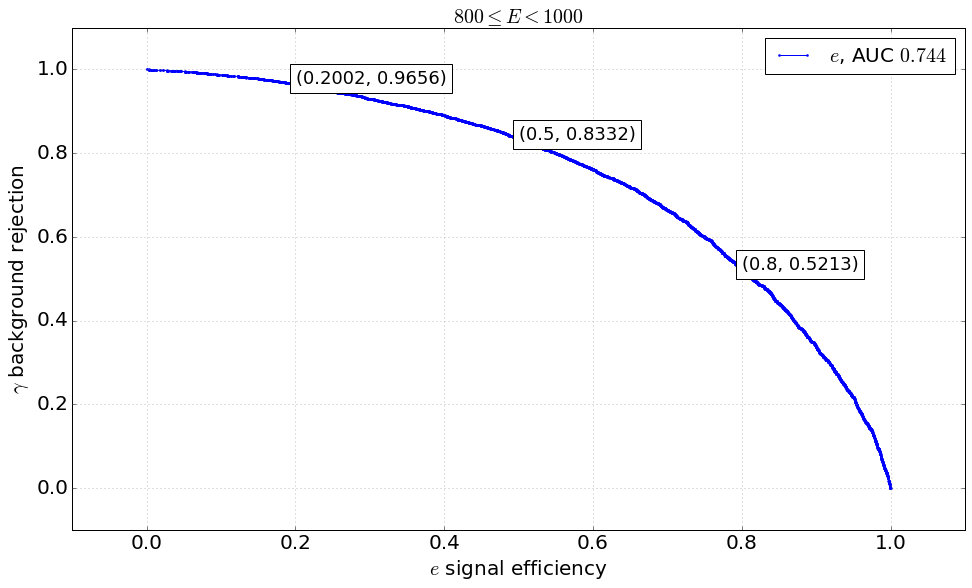

-------------------------------------------------------------
Plotting the ROC curve for CNN model trained using 45000 samples
-------------------------------------------------------------


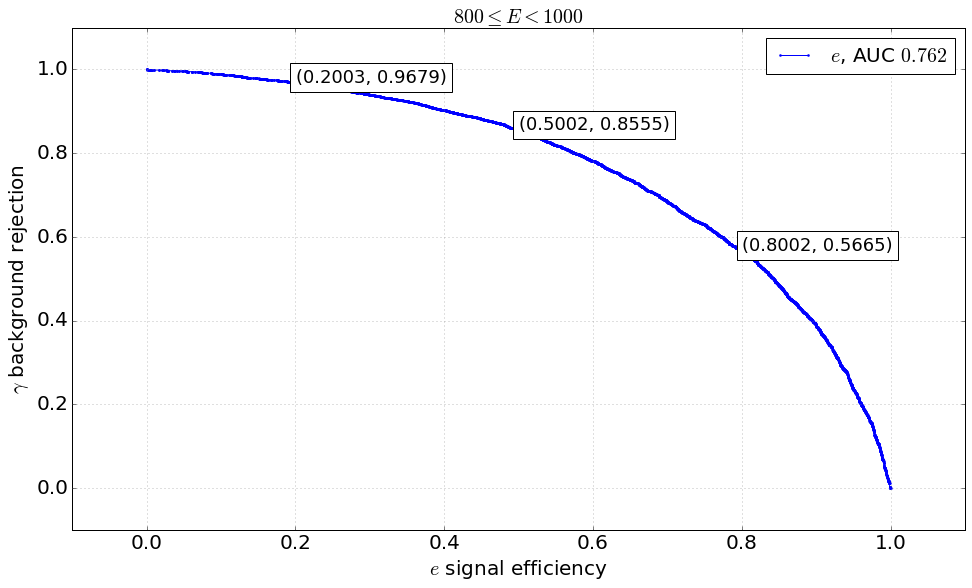

-------------------------------------------------------------
Plotting the ROC curve for CNN model trained using 90000 samples
-------------------------------------------------------------


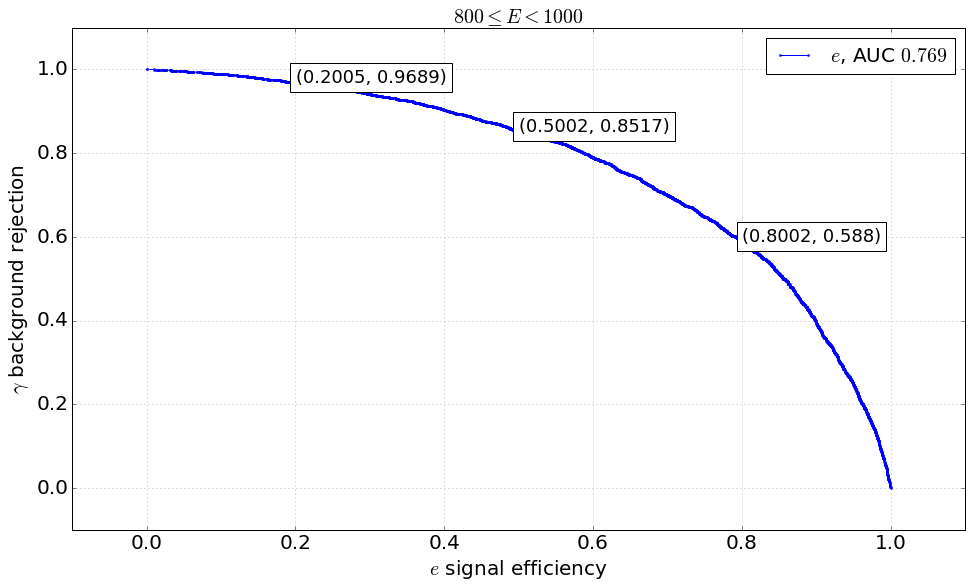

In [52]:
for num_sample, dump in zip(num_samples, dumps):
    
    print("-------------------------------------------------------------")
    print("Plotting the ROC curve for CNN model trained using {0} samples".format(num_sample))
    print("-------------------------------------------------------------")
    
    test_dump_path = dump_dir + dump + dump_file
    test_dump_np = np.load(test_dump_path)
    
    test_softmax  = test_dump_np['softmax'].reshape(-1, 3)
    test_labels   = test_dump_np['labels'].reshape(-1)
    test_energies = test_dump_np['energies'].reshape(-1)
    
    roc_metrics = plot_new_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "gamma", min_energy=800,
                               max_energy=1000, show_plot=True)